# Week 9 - Gradient Boosting

Include ideas such as gradient boost, learning rate, number of estimators, tree depth, and regularization

#### <font color='plum'> RESPONSES IN THIS COLOR

# Imports

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time

from sklearn.experimental   import enable_halving_search_cv  # Needed to enable
from imblearn.over_sampling import SMOTE
from sklearn.tree           import DecisionTreeClassifier
from imblearn.ensemble      import BalancedRandomForestClassifier

# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    HalvingGridSearchCV,
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

# # explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv # noqa
# # now you can import normally from model_selection
# from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)
from sklearn.decomposition  import PCA
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets       import make_regression
from datetime               import datetime, timedelta
from tqdm                   import tqdm
from typing                 import Any, Dict, List, Union, Tuple
from sklearn.base           import BaseEstimator
from collections            import Counter
from scipy.stats            import randint
from sklearn.preprocessing  import LabelEncoder
from sklearn.datasets       import make_regression
from sklearn.tree           import DecisionTreeClassifier, plot_tree
from sklearn.inspection     import permutation_importance

%matplotlib inline

from kagglehub              import KaggleDatasetAdapter

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Functions

In [157]:
# globals
RANDOM_STATE    = 42
TEST_SIZE       = 0.2
N_JOBS          = -1
font_size      = 8

In [158]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [159]:
def format_time(seconds):
    ''' Convert seconds to hours, minutes, and remaining seconds then Return a formatted string '''
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours               = int(seconds // 3600)
    minutes             = int((seconds % 3600) // 60)
    remaining_seconds   = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

#### plot_roc_auc_curve

In [160]:

def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    return ax



#### plot_precision_recall_curve

In [161]:


def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    # Get predicted probabilities for the positive class
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall pairs and average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot the precision-recall curve
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower left")
    plt.tight_layout()
    
    return ax


#### plot_confusion_matrix

In [162]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}", 
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    ax.set_title(f"Confusion Matrix - {model_name}\n {labels}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax




#### plot_feature_importance

In [163]:

def plot_feature_importance(search, X, title="Feature Importance", color="midnightblue", ax=None):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top).

        Parameters:
            - search: A fitted GridSearchCV or RandomizedSearchCV object with a tree-based estimator.
            - X: pandas DataFrame of features used to train the model.
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
    """
    # Get  best model from the search object
    best_model = search.best_estimator_

    # Check if  model has feature_importances_ attribute
    if not hasattr(best_model, "feature_importances_"):
        raise AttributeError("The best estimator does not have 'feature_importances_' attribute.")

    # Extract and sort feature importances
    importances         = best_model.feature_importances_
    sorted_indices      = np.argsort(importances)[::-1]
    sorted_features     = X.columns[sorted_indices]
    sorted_importances  = importances[sorted_indices]

    # Create plot if no Axes object is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=color)
    ax.invert_yaxis()  # Most important features at the top
    ax.set_xlabel("Importance")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


#### plot_metrics

In [164]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


#### check_early_stopping

In [165]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### get_parameter_list

In [166]:
def get_parameter_list(parameter: str,  
                       custom_list: list, 
                       df: pd.DataFrame
                       ):
    
    """
    Returns a list of parameter values based on the given parameter name, using a dictionary.

        Args:
            parameter: name of the parameter.
            custom_list: Optional list of custom values, which will override the values in parameter_dict.
            df: Optional DataFrame, used for calculating total features for 'max_features'.

        Returns:
            A list of parameter values.
    """

    parameter_dict = {
        'n_estimators': list(np.arange(50, 1001, 50)),
        'max_samples': [1.0],
        'max_depth': [None] + list(np.arange(2, 17, 2)),
        'bootstrap': [True, False],
        'learning_rate': list(np.arange(.01, .50, .05)),
        'min_samples_size': list(np.arange(1, 11)),
        'min_samples_leaf': list(np.arange(1, 11))
    }

    if custom_list is not None:
        parameter_dict[parameter] = custom_list

    if parameter == 'max_features':
        if df is None:
            raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
        if parameter_dict.get('max_features') is not None:
            return parameter_dict['max_features']
        else:
            total_features = df.shape[1]
            return list(range(2, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
    elif parameter in parameter_dict:
        return parameter_dict[parameter]
    
    else:
        return []
    

#### run_tree_classifier

In [167]:
def run_tree_classifier(X_train,
                        y_train,
                        X_test              = None,
                        y_test              = None,
                        classifier_type     = 'RandomForest', # 'DecisionTree', 'RandomForest', 'BalancedRandomForest', 'GradientBoosting'
                        model_name          = None,
                        classification_dict = {0: 'No Disease', 1: 'Disease'},
                        is_imbalanced      = False,
                        # Tree/Ensemble Parameters
                        n_estimators        = 100,
                        criterion           = 'gini',
                        max_depth           = None,
                        min_samples_split   = 2,
                        min_samples_leaf    = 1,
                        min_weight_fraction_leaf = 0.0,
                        max_features        = 'sqrt',
                        random_state        = 42,
                        max_leaf_nodes      = None,
                        min_impurity_decrease = 0.0,
                        ccp_alpha           = 0.0,
                        learning_rate       = 0.1,
                        # Ensemble Specific Parameters
                        bootstrap           = True,
                        oob_score           = False,
                        class_weight        = None,
                        sampling_type       = 'auto',
                        # CV and System Parameters
                        n_jobs              = -1,
                        n_splits            = 5,
                        n_repeats           = 5,
                        verbose             = 0):

        """
            A unified, robust function for training and evaluating various tree-based
            classification models, including standard Decision Tree, Random Forest, 
            and the imbalance-aware Balanced Random Forest.

            The function performs Repeated K-Fold Cross-Validation (CV) and calculates
            detailed metrics for a final test set.

            Parameters
            ----------
                X_train : pd.DataFrame or np.array
                    Training features.
                y_train : pd.Series or np.array
                    Training labels.
                X_test : pd.DataFrame or np.array, optional
                    Test features for final evaluation. Defaults to None.
                y_test : pd.Series or np.array, optional
                    Test labels for final evaluation. Defaults to None.
                classifier_type : str
                    The type of model to instantiate. Must be one of:
                    'DecisionTree', 'RandomForest', or 'BalancedRandomForest'.
                model_name : str, optional
                    A custom name for the model in the output report. If None, one is
                    derived from `classifier_type`.
                dict_outcome : dict
                    A dictionary mapping numerical labels to human-readable class names 
                    (e.g., {0: 'Negative', 1: 'Positive'}). Used for reporting.
                    
            Model Hyperparameters (See sklearn docs for full detail) 
            ----------
                n_estimators : int, optional
                    Number of trees in the forest (for Random Forest and BRF only). Default is 100.
                criterion : str, optional
                    The function to measure the quality of a split ('gini' or 'entropy').
                max_depth : int, optional
                    The maximum depth of the tree.
                min_samples_split : int, optional
                    The minimum number of samples required to split an internal node.
                min_samples_leaf : int, optional
                    The minimum number of samples required to be at a leaf node.
                max_features : str or float or int, optional
                    The number of features to consider when looking for the best split.
                random_state : int, optional
                    Controls the randomness of the estimator. Default is 42.
                oob_score : bool, optional
                    Whether to use out-of-bag samples to estimate the generalization accuracy 
                    (for ensemble models only).
                class_weight : str or dict, optional
                    Weights associated with classes (ignored for BalancedRandomForest).
                sampling_type : str, optional
                    For 'BalancedRandomForest' only. Defines how to sample the non-minority 
                    class ('auto', 'all', or 'not minority').

            CV and System Parameters
            ----------
                n_jobs : int, optional
                    Number of jobs to run in parallel. -1 means using all processors. 
                    Ignored for DecisionTree fit but used for CV.
                n_splits : int, optional
                    Number of splits for the Repeated K-Fold CV. Default is 5.
                n_repeats : int, optional
                    Number of times the K-Fold CV is repeated. Default is 5.

            Returns
            -------
                dict
                    A dictionary containing the following keys:
                    'metrics' : dict
                        Summary of mean CV metrics (accuracy, precision, recall, f1, f1_macro) 
                        and final test accuracy (if X_test/y_test provided).
                    'classifier' : object
                        The trained scikit-learn or imblearn classifier instance.
                    'y_pred' : np.array or None
                        The predicted labels for the test set (if X_test provided).
                    'cv_results' : dict
                        The raw results dictionary from `sklearn.model_selection.cross_validate`.
                    'confusion_matrix' : np.array or None
                        The confusion matrix calculated on the test set.
                    'classification_report' : str or None
                        The classification report (precision, recall, f1-score) on the test set.

            Raises
            ------
                ValueError
                    If an invalid `classifier_type` is provided.
        """

        start = time.time()

        classifier_type = classifier_type.lower()

        if model_name is None:
            model_name = classifier_type.replace('tree', ' Tree').replace('forest', ' Forest').title()

        base_params = {
            'criterion':                criterion,
            'max_depth':                max_depth,
            'min_samples_split':        min_samples_split,
            'min_samples_leaf':         min_samples_leaf,
            'min_weight_fraction_leaf': min_weight_fraction_leaf,
            'max_features':             max_features if classifier_type != 'decisiontree' else None,
            'random_state':             random_state,
            'max_leaf_nodes':           max_leaf_nodes,
            'min_impurity_decrease':    min_impurity_decrease,
            'ccp_alpha':                ccp_alpha,
            'class_weight':             class_weight,
            'n_jobs':                   n_jobs if classifier_type != 'decisiontree' else None
        }

        ensemble_params = {
            'n_estimators': n_estimators,
            'bootstrap':    bootstrap,
            'oob_score':    oob_score,
        }

        if classifier_type == 'decisiontree':
            for param in ['n_estimators', 'bootstrap', 'oob_score', 'n_jobs']:
                base_params.pop(param, None)
            model = DecisionTreeClassifier(**base_params)

        elif classifier_type == 'randomforest':
            model = RandomForestClassifier(**base_params, **ensemble_params)

        elif classifier_type == 'balancedrandomforest':
            base_params.pop('class_weight', None)
            model = BalancedRandomForestClassifier(
                **base_params,
                **ensemble_params,
                sampling_type = sampling_type
            )
            model_name = "Balanced Random Forest"

        elif classifier_type == 'gradientboosting':
                    # 1. Pop parameters not applicable to GradientBoosting
                    for param in ['bootstrap', 'oob_score', 'class_weight', 'n_jobs']:
                        base_params.pop(param, None)

                    # 2. **CRITICAL FIX: Pop the 'criterion' parameter**
                    #    This ensures only valid parameters remain in base_params for GBC.
                    base_params.pop('criterion', None)
                    
                    model = GradientBoostingClassifier(
                        **base_params,
                        n_estimators = n_estimators,
                        learning_rate = learning_rate
                    )
                    model_name = "Gradient Boosting"

        else:
            raise ValueError("Invalid 'classifier_type'. Choose 'DecisionTree', 'RandomForest', 'BalancedRandomForest', or 'GradientBoosting'.")

        repeated_cv = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = random_state)
        scoring     = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']

        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            scoring  = scoring,
            cv       = repeated_cv,
            n_jobs   = n_jobs if classifier_type != 'decisiontree' and classifier_type != 'gradientboosting' else None
        )

        model.fit(X_train, y_train)
        y_pred          = model.predict(X_test) if X_test is not None else None
        end             = time.time()
        execution_time  = format_hms(end - start)
        timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))


        results_dict = {
            'model_name':       model_name,
            'execution_time':   execution_time,
            'timestamp':        timestamp,
            'class_weight':     base_params.get('class_weight', 'N/A')
        }

        print(f"\n--- Final {model_name} Evaluation ---")
        mean_accuracy   = np.mean(cv_results['test_accuracy'])
        mean_precision  = np.mean(cv_results['test_precision'])
        mean_recall     = np.mean(cv_results['test_recall'])
        mean_f1         = np.mean(cv_results['test_f1'])
        mean_f1_macro   = np.mean(cv_results.get('test_f1_macro', np.nan))

        print(f"Mean CV Accuracy: {mean_accuracy:.4f}")
        print(f"Mean CV Precision: {mean_precision:.4f}")
        print(f"Mean CV Recall: {mean_recall:.4f}")
        print(f"Mean CV F1 Score: {mean_f1:.4f}")
        if not np.isnan(mean_f1_macro):
            print(f"Mean CV F1 Macro Score: {mean_f1_macro:.4f}\n")

        results_dict.update({
            'mean_cv_acc':       mean_accuracy,
            'mean_cv_precision': mean_precision,
            'mean_cv_recall':    mean_recall,
            'mean_cv_f1':        mean_f1,
            'mean_cv_f1_macro':  mean_f1_macro
        })

        if oob_score and hasattr(model, 'oob_score_'):
            print(f"OOB Score: {model.oob_score_:.4f}")
            results_dict['oob_score'] = model.oob_score_

        if X_test is not None and y_test is not None:
            accuracy       = accuracy_score(y_test, y_pred)
            conf_matrix    = confusion_matrix(y_test, y_pred)
            class_report   = classification_report(y_test, y_pred, target_names = classification_dict.values())

            print(f"Final Test Accuracy: {accuracy:.4f}\n")
            cm_df          = pd.DataFrame(conf_matrix, index=classification_dict.values(), columns=classification_dict.values())
            print("Confusion Matrix (Test Set)\n", cm_df, "\n")
            print("Classification Report (Test Set)\n", class_report)

            results_dict['test_acc'] = accuracy


        return {
            'metrics':              results_dict,
            'classifier':           model,
            'y_pred':               y_pred,
            # 'cv_results':           cv_results,
            # 'confusion_matrix':     conf_matrix if X_test is not None else None,
            # 'classification_report': class_report if X_test is not None else None
        }


#### run_GridSearch_RandomizedSearch_CV

In [228]:
import time
import inspect
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

def run_GridSearch_RandomizedSearch_CV(
    ensemble_model,
    dataset_name: str,
    parameter_grid: dict,
    X: pd.DataFrame,
    X_train,
    y_train,
    X_test,
    y_test,
    classification_dict: dict,
    CV_tuning_strategy: int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
    is_classifier: bool = True,
    iterations: int = 10,
    n_jobs: int = -1,
    verbose: bool = True,
    n_repeats: int = 10,
    cv_folds: int = 5,
    random_state: int = None,
    scoring_metric: str = 'accuracy',  # e.g., 'accuracy', 'f1', 'roc_auc'
    halving_factor: int = 2,
    is_imbalanced: bool = False
) -> tuple:
    """
    Consolidated function for hyperparameter tuning using GridSearchCV, RandomizedSearchCV, or HalvingGridSearchCV.
    """

    # Initialize model with random_state if supported
    if isinstance(ensemble_model, type):
        model_init_params = inspect.signature(ensemble_model).parameters
        if 'random_state' in model_init_params:
            model = ensemble_model(random_state=random_state)
        else:
            model = ensemble_model()
    else:
        model = ensemble_model

    model_name = model.__class__.__name__

    # Common search parameters
    search_params = {
        'n_jobs': n_jobs,
        'verbose': verbose,
        'cv': cv_folds,
        'scoring': scoring_metric,
        'return_train_score': True,
        'estimator': model
    }

    # Select search strategy
    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'
        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions=parameter_grid,
            n_iter=iterations,
            random_state=random_state,
            **search_params
        )
    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'
        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid=parameter_grid,
            factor=halving_factor,
            **search_params
        )
    elif CV_tuning_strategy == 2:
        search_type = 'GridSearchCV'
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_grid=parameter_grid,
            **search_params
        )
    else:
        raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")

    # Fit and evaluate
    start = time.time()
    search.fit(X_train, y_train)
    end = time.time()

    cv_results_df = pd.DataFrame(search.cv_results_)

    print(f"\nBest Parameters: {search.best_params_}")
    best_score = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred = search.best_estimator_.predict(X_test)

    # Handle imbalanced datasets
    if is_imbalanced:
        print("Dataset is imbalanced. Using balanced accuracy.\n")
        test_score = balanced_accuracy_score(y_test, y_pred)
    else:
        test_score = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time  = format_hms(end - start)
    timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f"Execution Time: {execution_time} seconds")
    print(f'Completed at: {timestamp}')

    # Classification report and plots
    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

        train_preds     = search.best_estimator_.predict(X_train)
        train_accuracy  = balanced_accuracy_score(y_train, train_preds) if is_imbalanced else accuracy_score(y_train, train_preds)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels = [v for v in classification_dict.values()] if classification_dict else None
        fig, ax = plt.subplots(2, 2, figsize=(15, 9))
        ax      = ax.flatten()
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize=12, fontweight='bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title=f'{model_name} ROC AUC Curve', ax=ax[0])
        plot_precision_recall_curve(search.best_estimator_, X_test, y_test, title=f'{model_name} Precision-Recall Curve', ax=ax[1])
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax=ax[2])
        plot_feature_importance(search, X, title=f'{model_name} Feature Importance\n{classification_dict}', color='midnightblue', ax=ax[3])

        plt.tight_layout()
        plt.show()

    # Collect best params
    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df['Dataset']           = dataset_name
    best_params_df['Model']             = model_name
    best_params_df['Strategy']          = search_type
    best_params_df['Scoring_Metric']    = scoring_metric
    best_params_df['Best_CV_Score']     = best_score
    best_params_df['Test_Accuracy']     = test_score
    best_params_df['execution_time']    = execution_time
    best_params_df['timestamp']         = timestamp

    return best_params_df, cv_results_df, search


### feature_selection

In [169]:

def feature_selection(X, y, model, 
                      direction             = 'forward', 
                      # 💡 KEY CHANGE: Use a classification metric like 'accuracy'
                      scoring               = 'accuracy', 
                      cv                    = 5, 
                      tol                   = None, 
                      n_features_to_select  = None, 
                      n_jobs                = -1,
                      verbose               = False,
                      exp_factor            = 1):
    """
    Performs forward or backward feature selection and returns results in a dictionary.
    
    A lower score is always considered 'better' for the selection process.
    Classification metrics (like 'accuracy', 'f1') are negated to be minimized.
    """

    start = time.time()

    # Helper to compute the CV score
    def cv_score(features):
        raw_score = cross_val_score(model, X[features], y, 
                                    scoring = scoring, cv = cv, n_jobs = n_jobs).mean()
        
        #  ADJUSTED LOGIC: Most classification scores are *positive* (to be maximized),
        # so we negate them (and take the exp_factor power) for minimization.
        # Regression scores starting with 'neg_' are already set up for minimization.
        if scoring.startswith('neg_'):
            # The minimization goal is already built-in, but we still apply exp_factor
            return (-raw_score) ** exp_factor 
        else:
            # For positive-is-better metrics (like 'accuracy'), we negate them for minimization.
            return (1 / raw_score) if scoring == 'r2' else (-raw_score) ** exp_factor

    # Set up initial state based on direction
    if direction == 'forward':
        current_features        = []
        candidate_features      = list(X.columns)
        stop_condition          = lambda: len(current_features) >= (n_features_to_select or len(X.columns))
        print_action            = 'Adding'
        scores_history          = []
        ordered_features        = []
        # Initial best score must be better than anything possible (i.e., -inf for our negated/minimized scores)
        best_score              = float('inf') 
        previous_score          = float('inf') 

    elif direction == 'backward':
        current_features        = list(X.columns)
        candidate_features      = list(X.columns)
        stop_condition          = lambda: len(current_features) <= (n_features_to_select or 1)
        print_action            = 'Removing'
        initial_score           = cv_score(current_features)
        scores_history          = [initial_score]
        ordered_features        = []
        # Initial best score is the full set score
        best_score              = initial_score 
        previous_score          = initial_score

    else:
        raise ValueError("Direction must be 'forward' or 'backward'.")

    #  rest of the logic remains sound for both directions and models, as it relies on finding the *minimum* (best) score.
    best_feature_set = current_features.copy()
    
    # Main loop
    round_num = 1
    while not stop_condition():
        if verbose:
            print(f"\nRound {round_num}:")
            
        scores = {}
        # Determine features to iterate over for the 'trial' set creation
        features_to_try = candidate_features if direction == 'forward' else current_features
        
        for feature in features_to_try:
            if direction == 'forward':
                trial_features = current_features + [feature]
            else: # backward
                # No need for 'if feature not in current_features: continue' because 
                # 'features_to_try' is explicitly 'current_features' in backward
                trial_features = [f for f in current_features if f != feature]
            
            # Skip if trial set is empty (only possible in backward selection if n_features_to_select is 0)
            if not trial_features:
                continue

            trial_score = cv_score(trial_features)
            scores[feature] = trial_score

            if verbose:
                action_text = f"Trying {print_action} feature '{feature}'"
                print(f"{action_text.ljust(35)} - Score: {trial_score:,.4f}")

        # If no features were left to try, break
        if not scores:
            break
            
        # Find the best feature to add/remove in this round (minimum score is best)
        best_feature_in_round   = min(scores, key=scores.get)
        current_score           = scores[best_feature_in_round]
        
        # Check for early stopping
        score_change = abs(previous_score - current_score)
        # 💡 CRITICAL LOGIC FOR CLASSIFICATION: In feature selection, you often stop if 
        # the *new* score is *worse* than the *previous* one, or the improvement is minimal.
        # Since we minimize the score, a *positive* change means the score got *worse*.
        if tol is not None and (score_change < tol or (direction == 'forward' and current_score > previous_score)):
            if verbose:
                print("\nStopping early due to minimal score change or score degradation.")
            break
            
        # Update current feature set and the ordered list
        if direction == 'forward':
            current_features.append(best_feature_in_round)
            candidate_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        else: # backward
            current_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        
        scores_history.append(current_score)
        previous_score = current_score

        # Track the overall best feature set and score
        if current_score < best_score:
            best_score              = current_score
            best_feature_set = current_features.copy()

        if verbose:
            features_display = current_features if direction == 'forward' else current_features
            print(f"\n{print_action} '{best_feature_in_round}' - New Feature Set Size: {len(current_features)}, Score: {current_score:,.4f}")
        
        round_num += 1

    end             = time.time()
    execution_time  = format_time(end - start)
    time_stamp      = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f"Execution Time: {execution_time}")

    return {
        'direction':                   direction,
        'selected_features_in_order':  ordered_features, 
        'scores_at_each_step':         scores_history, 
        'best_feature_set_found':      best_feature_set, 
        'best_score':                  best_score, 
        'exp_factor':                  exp_factor,
        'execution_time':              execution_time,
        'timestamp':                   time_stamp
    }

### prepare_data

In [219]:

def prepare_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float    = 0.2,
    random_state: int   = 42,
    scaler_type: str    = None  # Default is None
) -> tuple:
    """
    Prepares a clean DataFrame for modeling by separating features and target,
    performing an 80/20 train-test split, and optionally scaling numeric features.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing features and the target variable.
    target_col : str
        The name of the target column in the DataFrame.
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split.
    random_state : int, default=42
        Random seed for reproducibility.
    scaler_type : str or None, default=None
        Type of scaler to use: "standard", "minmax", or None for no scaling.

    Returns
    -------
    tuple
        (X_train_final, X_test_final, y_train, y_test, X_df)
    """

    # Encode target variable
    le = LabelEncoder()
    df[target_col]  = le.fit_transform(df[target_col])
    target_labels   = [str(label) for label in le.classes_]
    print(f"Target variable '{target_col}' encoded successfully.")

    # Drop NaNs and duplicates
    initial_rows    = df.shape[0]
    df_clean        = df.dropna().drop_duplicates().reset_index(drop=True)
    final_rows      = df_clean.shape[0]
    print(f"Dropped rows with NaNs and duplicates.\nInitial rows: {initial_rows}, Final rows: {final_rows}")
    print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")
    df = df_clean.copy()

    # Feature and target separation
    X_df    = df.drop(columns=[target_col])
    y       = df[target_col]

    # Coerce feature columns to numeric
    for col in X_df.columns:
        X_df[col] = pd.to_numeric(X_df[col], errors='coerce')
    print("Applied type coercion to feature columns.")

    all_features = X_df.columns.tolist()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size = test_size, random_state = random_state, stratify = y
    )
    print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")

    # Scaling logic
    if scaler_type is None:
        print("No scaling applied. Returning original feature values.")
        X_train_final   = pd.DataFrame(X_train, columns=all_features)
        X_test_final    = pd.DataFrame(X_test, columns=all_features)
    else:
        print("--- Manual Feature Scaling ---")
        if scaler_type == "standard":
            scaler = StandardScaler()
            print("Using StandardScaler for feature scaling.")
        elif scaler_type == "minmax":
            scaler = MinMaxScaler()
            print("Using MinMaxScaler for feature scaling.")
        else:
            raise ValueError("Invalid scaler_type. Choose 'standard', 'minmax', or None.")

        X_train_scaled  = scaler.fit_transform(X_train)
        X_test_scaled   = scaler.transform(X_test)

        X_train_final   = pd.DataFrame(X_train_scaled, columns=all_features)
        X_test_final    = pd.DataFrame(X_test_scaled, columns=all_features)
        print("Scaling Complete.\n")

    return X_train_final, X_test_final, y_train, y_test, X_df


### engineer_features_diabetes

In [177]:
def engineer_features_diabetes(df, drop_originals = True):
    df_eng = df.copy()
    
    
    # Risk Factor Count, Summing boolean/binary columns (0s and 1s)
    risk_cols                       = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack']
    df_eng['Risk_Count']            = df_eng[risk_cols].sum(axis=1)
    
    # Total Unhealthy Days
    df_eng['Total_Bad_Health_Days'] = df_eng['MentHlth'] + df_eng['PhysHlth']
    
    # Interaction: Age * BMI
    # (Optional: Scale these first if you want the product to be smaller)
    df_eng['Age_BMI_Interaction']   = df_eng['Age'] * df_eng['BMI']
    
    #  Binning BMI (Standard medical brackets)
    # Note: Check your BMI min/max to ensure bins cover data
    # <18.5 (Under), 18.5-25 (Normal), 25-30 (Over), >30 (Obese)
    bins                = [0, 18.5, 25, 30, 100]
    labels              = [0, 1, 2, 3] # Ordinal encoding ensures order is preserved
    df_eng['BMI_Cat']   = pd.cut(df_eng['BMI'], bins = bins, labels = labels).astype(int)
    
    # 5. IMPORTANT: Drop original columns to reduce dimensionality
    # For KNN, simpler is often better; try dropping the components 
    # just combined (like the individual risk cols) to see if accuracy goes up.
    # df_eng = df_eng.drop(columns=risk_cols) 
    cols_to_drop = [
    'HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', # Replaced by Risk_Count
    'MentHlth', 'PhysHlth' # Replaced by Total_Bad_Health_Days
    ]

    if drop_originals:
        df_eng = df_eng.drop(columns = cols_to_drop)
    
    return df_eng


### engineer_ckd_features

In [197]:

def engineer_features_ckd(df, drop_originals = True):
    df_eng = df.copy()
    
    # --- 1. Clinical Ratios ---
    # BUN/Creatinine Ratio
    # (Handling potential division by zero)
    df_eng['BUN_Creatinine_Ratio']  = df_eng['BUNLevels'] / df_eng['SerumCreatinine'].replace(0, 0.01)
    
    # Cholesterol Ratio (Total / HDL)
    # Adding small epsilon to avoid division by zero
    df_eng['Cholesterol_Ratio']     = df_eng['CholesterolTotal'] / (df_eng['CholesterolHDL'] + 0.01)

    # Mean Arterial Pressure (MAP)
    df_eng['MAP'] = (2 * df_eng['DiastolicBP'] + df_eng['SystolicBP']) / 3

    # --- 2. Risk Factor Aggregation ---
    fam_history_cols             = ['FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes']
    df_eng['FamilyHistoryScore'] = df_eng[fam_history_cols].sum(axis=1)

    exposure_cols           = ['HeavyMetalsExposure', 'OccupationalExposureChemicals']                              
    df_eng['ExposureScore'] = df_eng[exposure_cols].sum(axis=1)
    
    # --- 3. Symptom Burden ---
    symptom_cols            = ['Edema', 'FatigueLevels', 'NauseaVomiting', 'MuscleCramps', 'Itching']
    df_eng['Symptom_Score'] = df_eng[symptom_cols].sum(axis=1)

    # --- 4. Lifestyle Risk Score ---
    # Normalize Alcohol to 0-1 to match Smoking (0/1)
    alcohol_norm                    = df_eng['AlcoholConsumption'] / df_eng['AlcoholConsumption'].max()
    df_eng['Lifestyle_Risk_Score']  = df_eng['Smoking'] + alcohol_norm

    # --- 5. Metabolic Interaction ---
    metabolic_cols              = ['SystolicBP', 'FastingBloodSugar', 'BMI']
    df_eng['Metabolic_Stress']  = df_eng[metabolic_cols].prod(axis=1)

    # --- 6. Electrolyte Homeostasis Score ---
    # We calculate the sum of absolute Z-scores to measure "deviation from normal"
    electro_cols = ['SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 
                    'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus']
    
    scaler = StandardScaler()
    # Fit on the specific columns just for this calculation
    electro_scaled                          = scaler.fit_transform(df_eng[electro_cols])
    df_eng['Electrolyte_Homeostasis_Score'] = np.sum(np.abs(electro_scaled), axis=1)

    # --- 7. Dimensionality Reduction ---
    # Drop all columns that were used to create the new features
    # Note: We KEEP 'GFR' and 'SerumCreatinine' as they are critical continuous signals
    cols_to_drop = (
        fam_history_cols + 
        exposure_cols + 
        symptom_cols + 
        electro_cols +
        ['CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides'] +
        ['Smoking', 'AlcoholConsumption'] +
        ['SystolicBP', 'DiastolicBP'] + # Replaced by MAP & Metabolic Stress
        ['BUNLevels'] + # Replaced by Ratio
        ['BMI'] # Replaced by Metabolic Stress
    )
    if drop_originals:
        df_eng = df_eng.drop(columns=cols_to_drop, errors='ignore')
    
    return df_eng

    # 4. GFR Staging (Medical Standard)
    # Stages: 5 (<15), 4 (15-29), 3b (30-44), 3a (45-59), 2 (60-89), 1 (>=90)
    # We map them to numeric codes 0-5 where 5 is worst (Stage 5) to keep linearity for KNN
    # bins                = [-1, 15, 30, 45, 60, 90, 1000]
    # labels              = [5, 4, 3, 2, 1, 0] # Higher score = Worse Health
    # df_eng['GFR_Stage'] = pd.cut(df_eng['GFR'], bins=bins, labels=labels).astype(int)
    # KNN relies on "distance." In a distance-based algorithm, preserving the continuous nature of GFR is more beneficial than binning it.
    # Raw GFR provides a continuous, precise distance signal (e.g., the difference between GFR 55 and GFR 30 is measurable).
    # Binned GFR_Stage lumps everyone into broad buckets (0, 1, 2, 3). Two patients with GFR 30 and 44 are treated as "identical" (distance = 0) in that dimension. For a distance-based algorithm like KNN, losing that granularity hurt the model more than the "cleaner" categories helped.


### get_num_cat_cols_diabetes

In [173]:
def get_num_cat_cols_diabetes(df:pd.DataFrame, target_col_name:str):
    X           = df.drop(columns = [target_col_name]) 
    y           = df[target_col_name] 

    numeric_cols        = []
    categorical_cols    = [] # These are binary (0/1) based on the user's definition

    # Use column names from X directly
    feature_cols        = X.columns.tolist()

    for col in feature_cols:
    
        # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
        if X[col].nunique() > 2: # type: ignore
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    print("\n--- Feature Classification Summary ---")
    print(f"Total Features: {len(feature_cols)}")
    print(f"Numeric Features (to be scaled): {numeric_cols}")
    print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")
    
    return numeric_cols, categorical_cols, feature_cols, X, y

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [183]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

dataset_3a = 'Diabetes Health Indicators'
#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 


df_3a.head(n = 5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [184]:
target_col  = 'Diabetes_binary'

numeric_cols, categorical_cols, feature_cols, X, y = get_num_cat_cols_diabetes(df_3a, target_col)

dict_outcome_diabetes = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']



In [185]:

# Create features & drop original columns
diab_engineered_df = engineer_features_diabetes(df_3a, drop_originals=False)
diab_engineered_df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,30.0,0.0,1.0,4.0,6.0,8.0,1.0,35.0,104.0,2
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,12.0,6.0,8.0,4.0,0.0,312.0,2
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,10.0,0.0,1.0,13.0,6.0,8.0,0.0,10.0,338.0,2
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,3.0,0.0,1.0,11.0,6.0,8.0,3.0,3.0,308.0,2
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,8.0,5.0,8.0,1.0,0.0,232.0,2


In [186]:
numeric_cols, categorical_cols, feature_cols, X, y = get_num_cat_cols_diabetes(diab_engineered_df, target_col)


--- Feature Classification Summary ---
Total Features: 25
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'Risk_Count', 'Total_Bad_Health_Days', 'Age_BMI_Interaction', 'BMI_Cat']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']



In [187]:

X_train_diab, X_test_diab, y_train_diab, y_test_diab, X_df_diab = prepare_data(
    df              = diab_engineered_df,
    target_col      = 'Diabetes_binary',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE,
    scaler_type     = None  # "standard" or "minmax" 
)

Target variable 'Diabetes_binary' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 70692, Final rows: 69057
Percentage of data retained: 97.69%

Applied type coercion to feature columns.
Data Split: Training set size = 55245, Test set size = 13812

No scaling applied. Returning original feature values.


### Diabetes | Gradient Boosting Classifier:  Baseline

In [188]:
model_diab_gbc_baseline = run_tree_classifier(
    X_train             = X_train_diab,
    y_train             = y_train_diab,
    X_test              = X_test_diab,
    y_test              = y_test_diab,
    classifier_type     = 'GradientBoosting',
    model_name          = 'diab_gbc_baseline',
    classification_dict =  dict_outcome_diabetes,
    n_estimators        = 400,
    max_depth           = 5,
    learning_rate       = 0.01,
    min_samples_split   = 4,
    min_samples_leaf    = 2
)


--- Final Gradient Boosting Evaluation ---
Mean CV Accuracy: 0.7481
Mean CV Precision: 0.7309
Mean CV Recall: 0.7982
Mean CV F1 Score: 0.7631
Mean CV F1 Macro Score: 0.7471

Final Test Accuracy: 0.7479

Confusion Matrix (Test Set)
                No Diabetes  Pre-/Diabetes
No Diabetes           4706           2086
Pre-/Diabetes         1396           5624 

Classification Report (Test Set)
                precision    recall  f1-score   support

  No Diabetes       0.77      0.69      0.73      6792
Pre-/Diabetes       0.73      0.80      0.76      7020

     accuracy                           0.75     13812
    macro avg       0.75      0.75      0.75     13812
 weighted avg       0.75      0.75      0.75     13812



In [189]:
model_diab_gbc_baseline

{'metrics': {'model_name': 'Gradient Boosting',
  'execution_time': '00:02:22',
  'timestamp': '2025-11-20 14:45:08',
  'class_weight': 'N/A',
  'mean_cv_acc': np.float64(0.7480894198570007),
  'mean_cv_precision': np.float64(0.7308775437327237),
  'mean_cv_recall': np.float64(0.798244727676152),
  'mean_cv_f1': np.float64(0.7630637478396883),
  'mean_cv_f1_macro': np.float64(0.7470630626081274),
  'test_acc': 0.7479003764842166},
 'classifier': GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                            min_samples_leaf=2, min_samples_split=4,
                            n_estimators=400, random_state=42),
 'y_pred': array([0, 0, 1, ..., 0, 1, 0], shape=(13812,))}


--- Visualizing Confusion Matrix ---


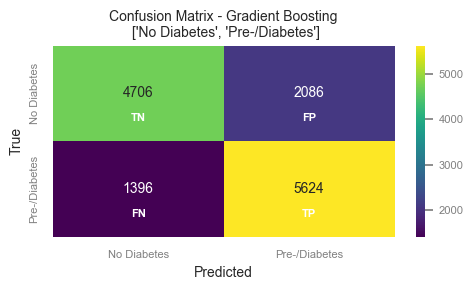


--- Generating Performance Curves ---


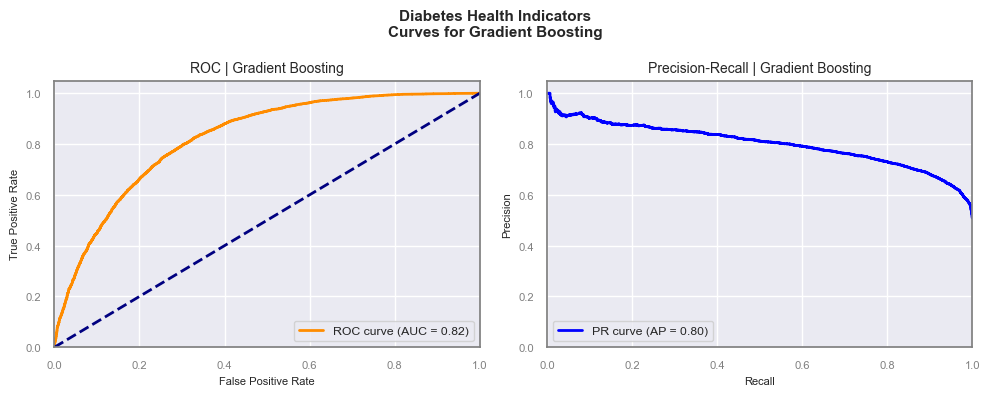

In [190]:
# VISUALIZATION: Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize = (5, 3))

plot_confusion_matrix(
    y_test_diab,
    model_diab_gbc_baseline['y_pred'],
    model_name   = model_diab_gbc_baseline['metrics']['model_name'],
    labels       = list(dict_outcome_diabetes.values()),
    ax           = plt.gca()
)
plt.show()


# ---  Model Visualization (ROC AUC and Precision-Recall) ---

print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (10, 4))

# ROC AUC Curve
plt.subplot(1, 2, 1)
plt.suptitle(f'{dataset_3a}\nCurves for {model_diab_gbc_baseline["metrics"]["model_name"]}', fontsize = 11, fontweight='bold')
plot_roc_auc_curve(
    model_diab_gbc_baseline['classifier'],
    X_test_diab,
    y_test_diab,
    title   = f'ROC | {model_diab_gbc_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Precision-Recall curve u
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    model_diab_gbc_baseline['classifier'],
    X_test_diab,
    y_test_diab,
    title   = f'Precision-Recall | {model_diab_gbc_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

In [191]:
results_diab_gbc_baseline_df = pd.DataFrame([model_diab_gbc_baseline['metrics']], index = [0])
results_diab_gbc_baseline_df

,model_name,execution_time,timestamp,class_weight,mean_cv_acc,mean_cv_precision,mean_cv_recall,mean_cv_f1,mean_cv_f1_macro,test_acc
0,Gradient Boosting,00:02:22,2025-11-20 14:45:08,N/A,0.748089,0.730878,0.798245,0.763064,0.747063,0.7479


### Diabetes | GBClassifier: GridSearchCV, all Features

In [193]:

diab_GBC_param_grid = {
    'n_estimators': list(range(250, 501, 50)),        # Controls number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],     # Lower LR often needs more estimators
    'max_depth': [3, 4, 5],                 # Depth of individual trees
    'subsample': [0.8, 1.0],                # Stochastic gradient boosting
    'max_features': ['sqrt', 'log2'],       # Feature selection per split
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]           # Minimum samples at leaf
}


Using HalvingGridSearchCV with halving factor 2...
n_iterations: 11
n_required_iterations: 11
n_possible_iterations: 11
min_resources_: 53
max_resources_: 55245
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1944
n_resources: 53
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
----------
iter: 1
n_candidates: 972
n_resources: 106
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
----------
iter: 2
n_candidates: 486
n_resources: 212
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
----------
iter: 3
n_candidates: 243
n_resources: 424
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
----------
iter: 4
n_candidates: 122
n_resources: 848
Fitting 5 folds for each of 122 candidates, totalling 610 fits
----------
iter: 5
n_candidates: 61
n_resources: 1696
Fitting 5 folds for each of 61 candidates, totalling 305 fits
----------
iter: 6
n_candidates: 31
n_resources: 3392
Fitting 5 folds for each of 31 candidat

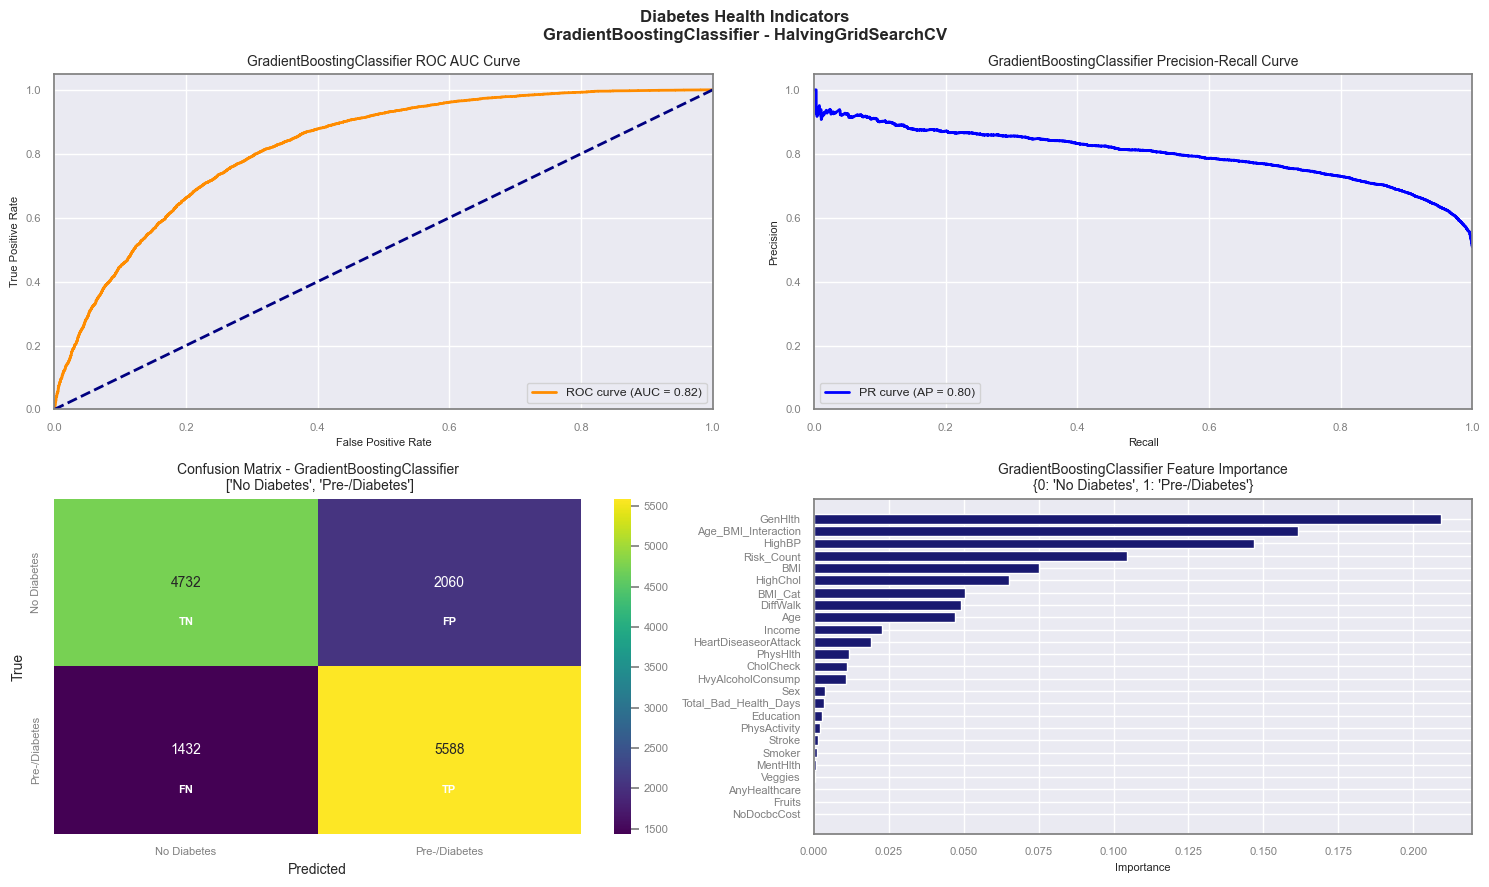

<Figure size 640x480 with 0 Axes>

In [194]:
results_diab_GBC_allFeatures_gridCV = run_GridSearch_RandomizedSearch_CV(
    ensemble_model       = GradientBoostingClassifier,
    dataset_name         = 'Diabetes Health Indicators',
    parameter_grid       = diab_GBC_param_grid,
    X                    = diab_engineered_df.drop(columns = ['Diabetes_binary']),
    X_train              = X_train_diab,
    y_train              = y_train_diab,
    X_test               = X_test_diab,
    y_test               = y_test_diab,
    classification_dict  = dict_outcome_diabetes,
    CV_tuning_strategy   = 1,  # HalvingGridSearchCV
    iterations           = 5,
    cv_folds             = 5,
    random_state         = RANDOM_STATE,  
    scoring_metric       = 'accuracy'
)

best_params_GBC_diab_allFeatures_df = results_diab_GBC_allFeatures_gridCV[0]

In [196]:
best_params_GBC_diab_allFeatures_df

,learning_rate,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,subsample,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,Test_Accuracy,execution_time,timestamp
0,0.01,3,log2,2,5,500,0.8,Diabetes Health Indicators,GradientBoostingClassifier,HalvingGridSearchCV,accuracy,0.745937,0.747176,00:09:04,2025-11-20 14:59:20


## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [204]:
file_path = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name = "Chronic_Kidney_Dsease_data.csv"

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

# df_3c.head()
df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']  # Columns to drop
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')  # Drop specified columns
target_col          = 'Diagnosis'
categorical_cols    = []
numeric_cols        = []


# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}

In [205]:
df_3c

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MuscleCramps,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
0,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,...,4.518513,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1
1,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,...,2.202222,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1
2,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,...,5.967271,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1
3,40,0,2,0,1,31.329680,0,16.020165,0.408871,6.964422,...,2.176387,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1
4,43,0,1,1,2,23.726311,0,7.944146,0.780319,3.097796,...,6.800993,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,90,0,0,1,2,39.677059,1,1.370151,4.157954,8.602873,...,6.972093,2.138976,81.102765,0,0,0,0.951836,9.547583,2.046212,0
1655,34,0,0,2,1,28.922015,0,3.372073,9.647525,9.836919,...,0.465297,7.911566,10.600428,0,1,0,3.604147,1.609847,0.324417,0
1656,84,0,0,2,3,21.951219,0,15.825955,7.349964,5.038194,...,2.281970,0.015531,69.633427,0,0,0,0.801955,5.768617,4.935108,0
1657,90,0,0,2,2,24.964149,0,12.967462,0.618614,4.557577,...,0.257814,3.432765,31.858023,0,0,0,0.560298,2.744519,0.322592,1


In [206]:
# show distribution of target variable
df_3c['Diagnosis'].value_counts()

Diagnosis
1    1524
0     135
Name: count, dtype: int64

In [207]:
CKD_engineered_df = engineer_features_ckd(df_3c, drop_originals=False)

# Check the new shape
print(f"Original Feature Count: {df_3c.shape[1]}")
print(f"New Feature Count: {CKD_engineered_df.shape[1]}")

Original Feature Count: 52
New Feature Count: 61


In [212]:
CKD_engineered_df

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,Diagnosis,BUN_Creatinine_Ratio,Cholesterol_Ratio,MAP,FamilyHistoryScore,ExposureScore,Symptom_Score,Lifestyle_Risk_Score,Metabolic_Stress,Electrolyte_Homeostasis_Score
0,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,...,1,5.159857,9.451682,93.000000,0,0,22.630953,1.256499,2.545740e+05,4.351878
1,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,...,1,9.927197,2.163179,84.666667,2,0,14.722613,1.930817,3.593300e+05,3.374655
2,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,...,1,10.745169,14.164531,119.666667,0,1,17.641482,1.594338,8.849652e+05,3.493184
3,40,0,2,0,1,31.329680,0,16.020165,0.408871,6.964422,...,1,7.662962,4.034854,82.333333,0,0,23.476715,0.801300,6.909847e+05,3.942641
4,43,0,1,1,2,23.726311,0,7.944146,0.780319,3.097796,...,1,3.081146,11.961053,76.666667,0,0,14.049889,0.397352,1.910290e+05,2.625237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,90,0,0,1,2,39.677059,1,1.370151,4.157954,8.602873,...,0,10.590084,5.977452,102.666667,0,0,17.626082,1.068533,1.008050e+06,3.524392
1655,34,0,0,2,1,28.922015,0,3.372073,9.647525,9.836919,...,0,46.431262,9.338641,111.000000,0,1,14.066795,0.168665,2.703637e+05,3.834765
1656,84,0,0,2,3,21.951219,0,15.825955,7.349964,5.038194,...,0,56.374587,4.266000,107.333333,0,0,12.896617,0.791586,4.224282e+05,4.776729
1657,90,0,0,2,2,24.964149,0,12.967462,0.618614,4.557577,...,1,11.124152,9.996976,112.333333,0,0,9.687011,0.648609,4.020096e+05,4.092358


In [213]:
X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = CKD_engineered_df,
    # df              = df_3c,    
    target_col      = 'Diagnosis',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE
)

print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)
print(f'Updated feature list: {X_CKD.columns.tolist()}\n')

Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

No scaling applied. Returning original feature values.
X_train: (1327, 60)
y_train: (1327,)
X_test: (332, 60)
y_test: (332,)
Updated feature list: ['Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'ACR', 'SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus', 'HemoglobinLevels', 'CholesterolTotal', 'Choles

### CKD | GB Classifier: Baseline

In [217]:
model_CKD_gbc_baseline = run_tree_classifier(
    X_train             = X_train_CKD,
    y_train             = y_train_CKD,
    X_test              = X_test_CKD,
    y_test              = y_test_CKD,
    classifier_type     = 'GradientBoosting',
    model_name          = 'Gradient Boosting Classifier',
    classification_dict = classification_dict_CKD,
    n_estimators        = 200,
    max_depth           = 5,
    learning_rate       = 0.1,
    min_samples_split   = 4,
    min_samples_leaf    = 2
)


--- Final Gradient Boosting Evaluation ---
Mean CV Accuracy: 0.9248
Mean CV Precision: 0.9259
Mean CV Recall: 0.9980
Mean CV F1 Score: 0.9606
Mean CV F1 Macro Score: 0.5669

Final Test Accuracy: 0.9337

Confusion Matrix (Test Set)
         No CKD  CKD
No CKD       5   22
CKD          0  305 

Classification Report (Test Set)
               precision    recall  f1-score   support

      No CKD       1.00      0.19      0.31        27
         CKD       0.93      1.00      0.97       305

    accuracy                           0.93       332
   macro avg       0.97      0.59      0.64       332
weighted avg       0.94      0.93      0.91       332




--- Visualizing Confusion Matrix ---


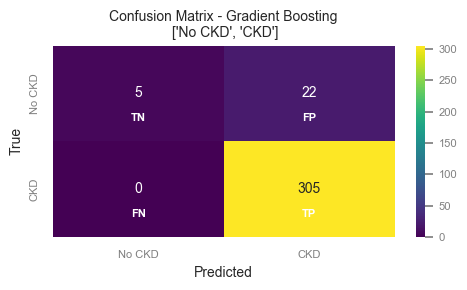


--- Generating Performance Curves ---


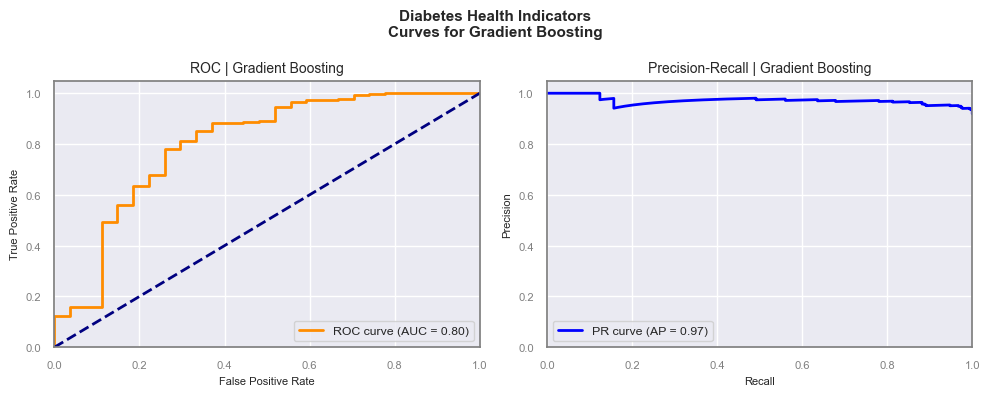

In [218]:
# VISUALIZATION: Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize = (5, 3))

plot_confusion_matrix(
    y_test_CKD,
    model_CKD_gbc_baseline['y_pred'],
    model_name   = model_CKD_gbc_baseline['metrics']['model_name'],
    labels       = list(classification_dict_CKD.values()),
    ax           = plt.gca()
)
plt.show()


# ---  Model Visualization (ROC AUC and Precision-Recall) ---

print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (10, 4))

# ROC AUC Curve
plt.subplot(1, 2, 1)
plt.suptitle(f'{dataset_3a}\nCurves for {model_CKD_gbc_baseline["metrics"]["model_name"]}', fontsize = 11, fontweight='bold')
plot_roc_auc_curve(
    model_CKD_gbc_baseline['classifier'],
    X_test_CKD,
    y_test_CKD,
    title   = f'ROC | {model_CKD_gbc_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Precision-Recall curve u
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    model_CKD_gbc_baseline['classifier'],
    X_test_CKD,
    y_test_CKD,
    title   = f'Precision-Recall | {model_CKD_gbc_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

### CKD | GB Classifier: GridSearchCV

In [223]:
from imblearn.over_sampling import SMOTE

print(f"Original Training Class Distribution: \n{y_train_CKD.value_counts()}")

# Initialize SMOTE
smote = SMOTE(random_state = RANDOM_STATE)

# Resample the training data ONLY
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_CKD, y_train_CKD)
print(f"Resampled Training Class Distribution: \n{y_train_resampled.value_counts()}")
# expecting equal numbers for both classes (e.g., 1000 vs 1000)

Original Training Class Distribution: 
Diagnosis
1    1219
0     108
Name: count, dtype: int64
Resampled Training Class Distribution: 
Diagnosis
1    1219
0    1219
Name: count, dtype: int64


In [232]:

CKD_GBC_param_grid = {
    'n_estimators':     list(range(250, 501, 50)),     # Controls number of boosting stages
    'learning_rate':    [0.01, 0.05, 0.1],             # Lower LR often needs more estimators
    'max_depth':        [3, 4, 5],                     # Depth of individual trees
    'subsample':        [0.8, 1.0],                    # Stochastic gradient boosting
    'max_features':     ['sqrt', 'log2'],              # Feature selection per split
    'min_samples_split':[2, 5, 10],                    # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]                      # Minimum samples at leaf
}

Using HalvingGridSearchCV with halving factor 2...
n_iterations: 7
n_required_iterations: 11
n_possible_iterations: 7
min_resources_: 20
max_resources_: 1327
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1944
n_resources: 20
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
----------
iter: 1
n_candidates: 972
n_resources: 40
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
1944 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1944 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arunram/.pyenv/versions/3.

----------
iter: 2
n_candidates: 486
n_resources: 80
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.93333333 0.93333333 0.93333333 ... 0.97192118 0.97192118 0.97192118]
  warnings.warn(
/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the train scores are non-finite: [1. 1. 1. ... 1. 1. 1.]
  warnings.warn(


----------
iter: 3
n_candidates: 243
n_resources: 160
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.93333333 0.93333333 0.93333333 ... 0.93559322 0.93559322 0.93559322]
  warnings.warn(
/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the train scores are non-finite: [1. 1. 1. ... 1. 1. 1.]
  warnings.warn(


----------
iter: 4
n_candidates: 122
n_resources: 320
Fitting 5 folds for each of 122 candidates, totalling 610 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.93333333 0.93333333 0.93333333 ... 0.95712578 0.95712578 0.95872099]
  warnings.warn(
/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the train scores are non-finite: [1. 1. 1. ... 1. 1. 1.]
  warnings.warn(


----------
iter: 5
n_candidates: 61
n_resources: 640
Fitting 5 folds for each of 61 candidates, totalling 305 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.93333333 0.93333333 0.93333333 ... 0.95636966 0.95636966 0.95715305]
  warnings.warn(
/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the train scores are non-finite: [1. 1. 1. ... 1. 1. 1.]
  warnings.warn(


----------
iter: 6
n_candidates: 31
n_resources: 1280
Fitting 5 folds for each of 31 candidates, totalling 155 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.93333333 0.93333333 0.93333333 ... 0.95871766 0.95953745 0.96186558]
  warnings.warn(
/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the train scores are non-finite: [1.         1.         1.         ... 0.98552967 0.99250212 1.        ]
  warnings.warn(



Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 1.0}
Best CV Score (f1): 0.9619
Dataset is imbalanced. Using balanced accuracy.

Test Accuracy: 0.5926
Execution Time: 00:05:44 seconds
Completed at: 2025-11-20 21:35:12

GradientBoostingClassifier - HalvingGridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.1852    0.3125        27
           1     0.9327    1.0000    0.9652       305

    accuracy                         0.9337       332
   macro avg     0.9664    0.5926    0.6388       332
weighted avg     0.9382    0.9337    0.9121       332

Train Accuracy: 1.0000
Test Accuracy: 0.5926


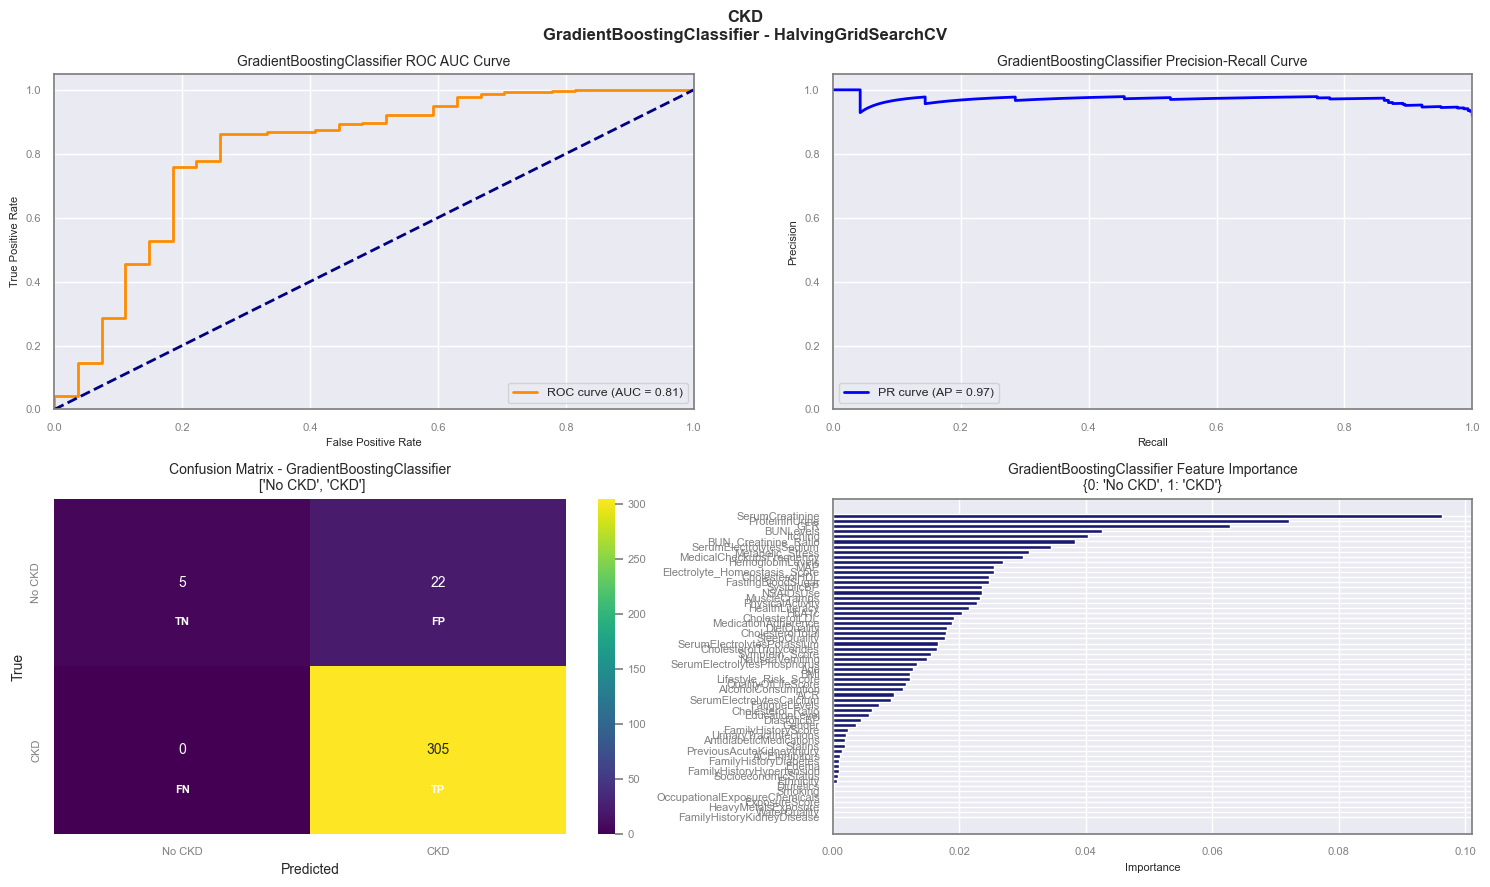

<Figure size 640x480 with 0 Axes>

In [233]:
results_CKD_GBC_gridCV = run_GridSearch_RandomizedSearch_CV(
    ensemble_model       = GradientBoostingClassifier,
    dataset_name         = 'CKD',
    parameter_grid       = CKD_GBC_param_grid,
    X                    = CKD_engineered_df.drop(columns = ['Diagnosis']),
    X_train              = X_train_CKD,
    y_train              = y_train_CKD,
    X_test               = X_test_CKD,
    y_test               = y_test_CKD,
    classification_dict  = classification_dict_CKD,
    CV_tuning_strategy   = 1,  # HalvingGridSearchCV
    iterations           = 10,
    cv_folds             = 5,
    random_state         = RANDOM_STATE,  
    scoring_metric       = 'f1',  # Using F1-score for imbalanced dataset
    is_imbalanced        = True
)

best_params_GBC_CKD_df   = results_CKD_GBC_gridCV[0]

In [ ]:
best_params_GBC_CKD_df

## Notes


### <font color='plum'><i>How is gradient boost similar to random forest? </i> 


Gradient Boosting and Random Forest are both **ensemble learning methods** used in machine learning, particularly for classification and regression tasks. They share some similarities but differ significantly in how they build and combine decision trees.

#### **Similarities**

1. **Ensemble Methods**: Both combine multiple decision trees to improve predictive performance.
2. **Tree-Based Models**: They use decision trees as base learners.
3. **Reduce Overfitting**: Both can reduce overfitting compared to a single decision tree, though in different ways.
4. **Feature Importance**: Both can be used to assess feature importance.
5. **Non-linear Modeling**: They can capture complex, non-linear relationships in data.

#### **Key Differences**

| Feature | **Random Forest** | **Gradient Boosting** |
|--------|-------------------|------------------------|
| **Tree Building** | Builds trees independently and in parallel | Builds trees sequentially, each correcting errors of the previous |
| **Model Combination** | Averages predictions (for regression) or majority vote (for classification) | Adds predictions from each tree to minimize error |
| **Bias-Variance Tradeoff** | Reduces variance | Reduces bias |
| **Training Speed** | Faster due to parallelism | Slower due to sequential nature |
| **Overfitting Risk** | Lower, especially with many trees | Higher, needs careful tuning (e.g., learning rate, number of trees) |
| **Robustness to Noise** | More robust | Less robust, sensitive to outliers |

#### **Use Cases**

- **Random Forest** is often preferred when:
  - You need a quick and robust model.
  - The data is noisy.
  - Interpretability is less critical.

- **Gradient Boosting** (e.g., XGBoost, LightGBM) is preferred when:
  - You want high accuracy and are willing to tune hyperparameters.
  - The dataset is clean and well-prepared.
  - You need better performance on structured/tabular data.

### <font color='plum'><i>How is gradient boost different from random forest?</i>

Gradient Boosting and Random Forest differ in **how they build and combine decision trees**, even though both are ensemble methods. Here's a breakdown of their **key differences**:

####  **1. Tree Construction Strategy**

- **Random Forest**:  
  - Builds **many trees independently** and in **parallel**.  
  - Each tree is trained on a **random subset** of the data and features (bagging).
  - Final prediction is made by **averaging** (regression) or **majority voting** (classification).

- **Gradient Boosting**:  
  - Builds trees **sequentially**, where each new tree tries to **correct the errors** of the previous ones.
  - Uses **gradient descent** to minimize a loss function.
  - Final prediction is a **weighted sum** of all trees.

####  **2. Bias vs. Variance**

- **Random Forest**:  
  - Focuses on **reducing variance** by averaging many deep trees.
  - Less prone to overfitting.

- **Gradient Boosting**:  
  - Focuses on **reducing bias** by learning from mistakes.
  - More prone to overfitting if not carefully tuned.

####  **3. Training Time**

- **Random Forest**:  
  - Faster to train due to parallelism.

- **Gradient Boosting**:  
  - Slower because trees are built one after another.

#### **4. Hyperparameter Sensitivity**

- **Random Forest**:  
  - Generally robust with fewer hyperparameters to tune.

- **Gradient Boosting**:  
  - Sensitive to parameters like **learning rate**, **number of trees**, and **tree depth**.
  - Requires careful tuning for optimal performance.

#### **Performance**

- **Random Forest**:  
  - Good baseline model, especially for noisy data.

- **Gradient Boosting**:  
  - Often achieves **higher accuracy** on structured/tabular data when properly tuned.


#### Summary Analogy

Think of it like this:
- **Random Forest** is like asking **100 independent experts** and taking the majority opinion.
- **Gradient Boosting** is like having **one expert learn from mistakes**, improving step by step.

### <font color='plum'><i>Does a small learning rate generally lead to higher or lower accuracy? Why?</i>

A **small learning rate** in gradient boosting generally leads to **higher accuracy**, but with some important caveats:

#### ✅ **Why a Small Learning Rate Can Improve Accuracy**

1. **More Precise Learning**:  
   A small learning rate means each tree makes only a small adjustment to the model. This allows the algorithm to **learn slowly and carefully**, reducing the risk of overfitting.

2. **Better Generalization**:  
   Because the model doesn't overreact to noise in the training data, it tends to generalize better to unseen data.

3. **Allows More Trees**:  
   You can use **more trees** to gradually improve the model, which often leads to better performance.


#### ⚠️ **Trade-offs and Considerations**

- **Training Time**:  
  A smaller learning rate requires **more trees** to reach optimal performance, which increases **training time**.

- **Diminishing Returns**:  
  If the learning rate is **too small**, the model might **underfit** or take too long to converge.

- **Hyperparameter Tuning**:  
  You need to balance learning rate with the **number of trees** and **tree depth**. A common strategy is to start with a small learning rate (e.g., 0.01 or 0.1) and increase the number of trees accordingly.

#### 📌 Rule of Thumb

- **Small learning rate + many trees** = **better accuracy**, but slower training.
- **Large learning rate + fewer trees** = faster training, but higher risk of overfitting or instability.


